In [1]:
prompt_dev = """

You are an AI assistant that generates Python scripts using Matplotlib to create diagrams illustrating science concepts.

You may be doing this task for the first time or as a redo based on feedback. 

Your output should be a json object with the following keys:
{
    "plan": "Your pseudocode plan or your steps to improve the diagram based on feedback.",
    "code": "Your Python code to generate the diagram.",
}

If you are doing this task for the first time:

- **Analyze** the text and identify key concepts that can be visually represented.
    - **Concepts**: The text will contain scientific concepts.
- **Scientific Accuracy**: Ensure the diagram is scientifically accurate and correctly represents the concepts.
- **Easy Digestion**: Make the diagram easy to understand and digest, ensuring that the key concepts are clearly communicated.
- **Plan** step-by-step what to include in the diagram, and write this plan in pseudocode with great detail.


If you are doing this task as a REDO:

- **Thoroughly review** your previous work and the subsequent feedback before proceeding.
    - You have access to your previously generated code, the resulting image and the feedback provided.
- **Aim to improve your performance** based on the feedback provided. Specifically, focus on the following:
    - **Scientific Accuracy**: Ensure the diagram accurately represents the scientific concept.
    - **Clarity**: Make the diagram as clear and easy to understand as possible. Consider labels, colors, and other visual elements.
    - **Adhere to Feedback**: If feedback exists in previous chat completion messages, adhere to the feedback strictly.


For both FIRST TIMERS and REDOERS:

- **Assume**: 
    - the following imports have been made.
        `import matplotlib.pyplot as plt
        import numpy as np`
    - the following variables are available to you:
        - 'folder': a string containing the folder name.
        - 'filename': a string containing the filename.
- **Code output** the complete Python code in a single code block.
    **Save** the plot: filepath should be combination of 'folder' and 'filename' which MUST be constructed and inserted as f string. (eg. ```plt.savefig(<insert-f-string>, format='png', dpi=300, bbox_inches='tight')```)

Your code should be complete and runnable as-is to generate the diagram.

Adhere STRICTLY to the output format specified:
{
    "plan": "...",
    "code": "...",
}

"""

In [2]:
prompt_qa = """

You are an AI assistant that critiques Matplotlib diagrams, especially those illustrating STEM concepts.

Your task is as follows:

1. **Analyze** the diagram provided.
2. **Identify** flaws in the diagram. Flaws can be both:
    - **Visual**: Issues with clarity, labeling, aesthetics, color choices, or any elements that may cause confusion or misinterpretation.
    - **Conceptual**: Errors in the representation of the underlying STEM concepts, inaccuracies in the data, or misinterpretations of the scientific principles.
3. **Provide a detailed critique**:
    - **Visual Flaws**: Describe each visual flaw clearly and suggest specific improvements.
    - **Conceptual Flaws**: Pinpoint exact conceptual faults, explain why they are incorrect, and provide step-by-step instructions to resolve them.
4. **If the diagram is correct** and has no flaws, state that it is correct.
5. **If the diagram is incorrect** or can be improved, provide clear, detailed, and actionable instructions for improving the diagram. These instructions should include:
    - Specific changes to the visual elements (e.g., labels, colors, line styles).
    - Corrections to the conceptual representation (e.g., correct formulas, accurate data representation).
    - If necessary, suggest completely redoing the work with a new approach or diagram.
6. **Ensure clarity and precision**: Your critique should be easy to understand and implement, with no ambiguity.

"""

ideas
- prompt_qa: add -> you have access to code and base64 image
- prompt_dev: add -> you have access to previous code, base64 image and critique...


- function which generates image -> returns dict : { 'image': 'true', 'base64': '......'}

- handle_tool_calls func in swarm.core should append an extra role: user message with base64 image

- run func in swarm.core should truncate earlier dev, image, qa messages so that an image is not sent a lot many times...


ABANDONED ABOVE STRATEGY!!!

Agentic workflow is not necessary for above use case. A simple loop, where each loop first creates an image and then QAs it is much simpler and controllable.




In [4]:
import requests

file_path = 'diagrams_v3/airfoil_lift_diagram.png'
response = requests.post("https://store6.gofile.io/uploadFile", files={"file": open(file_path, "rb")})
link = response.json()["data"]["downloadPage"]
print("Image URL:", link)


Image URL: https://gofile.io/d/cIDjb0


In [6]:
print(response.json())

{'data': {'createTime': 1730680870, 'downloadPage': 'https://gofile.io/d/cIDjb0', 'guestToken': 'fTkNogCvxfGULopV0g3WAA8oEhLuRp8p', 'id': 'e15c0599-6c60-4a0d-b559-bb49b60bf5a2', 'md5': '61113e362aa919069876e5df064f12eb', 'mimetype': 'image/png', 'modTime': 1730680870, 'name': 'airfoil_lift_diagram.png', 'parentFolder': 'c1e733f1-460b-43f5-9bdb-ce2a4164e906', 'parentFolderCode': 'cIDjb0', 'servers': ['store6'], 'size': 181097, 'type': 'file'}, 'status': 'ok'}


In [7]:
def get_image_url(response_json):
    data = response_json['data']
    server = data['servers'][0]
    file_id = data['id']
    filename = data['name']
    
    return f"https://{server}.gofile.io/download/web/{file_id}/{filename}"

In [10]:
link = get_image_url(response.json())

link

'https://store6.gofile.io/download/web/e15c0599-6c60-4a0d-b559-bb49b60bf5a2/airfoil_lift_diagram.png'

In [13]:
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "Critique the diagram. Identify any flaws and provide detailed feedback. Focus on scientific accuracy and visual clarity."},
        {
          "type": "image_url",
          "image_url": {
            "url": f"{link}",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

BadRequestError: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image has of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_image_format'}}

Above code doesn't work, try using Open AI's own example from their docs page

In [12]:
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image depicts a serene landscape featuring a wooden pathway leading through a lush green marsh or field. The pathway is bordered by tall grasses and small bushes, extending into a horizon dotted with trees. The sky is bright and partly cloudy, creating a peaceful atmosphere. This scene suggests an outdoor natural setting, likely ideal for walking or exploring nature.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))


Above OpenAI example works. Let's try validating the code

In [14]:
import requests

def validate_image_url(url):
    try:
        response = requests.head(url)
        print(f"Status Code: {response.status_code}")
        print(f"Content Type: {response.headers.get('content-type', 'Not specified')}")
        print(f"Headers: {dict(response.headers)}")
        return response.status_code == 200 and 'image' in response.headers.get('content-type', '')
    except Exception as e:
        print(f"Error accessing URL: {e}")
        return False

# Test URL
url = "https://store6.gofile.io/download/web/e15c0599-6c60-4a0d-b559-bb49b60bf5a2/airfoil_lift_diagram.png"
is_valid = validate_image_url(url)
print(f"\nIs valid image URL: {is_valid}")

Status Code: 302
Content Type: text/html; charset=utf-8
Headers: {'Server': 'nginx/1.27.1', 'Date': 'Mon, 04 Nov 2024 01:03:19 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Connection': 'keep-alive', 'Access-Control-Allow-Headers': 'Accept, Accept-Language, Content-Language, Content-Type, Content-Length, Range, Authorization', 'Access-Control-Allow-Methods': 'POST, GET, OPTIONS, PUT, DELETE', 'Access-Control-Allow-Origin': '*', 'Access-Control-Expose-Headers': 'Cache-Control, Content-Encoding, Content-Range', 'Location': 'https://gofile.io/d/c1e733f1-460b-43f5-9bdb-ce2a4164e906'}

Is valid image URL: False


Analysis
The output shows that:

We get a 302 (redirect) status code
Content-Type is text/html, not an image
The URL redirects to a download page, not direct image
Plan
Follow redirects to get final URL
Add User-Agent header to mimic browser
Use GET instead of HEAD to fully resolve redirects

In [15]:
def validate_image_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        # Use GET and allow redirects
        response = requests.get(url, headers=headers, allow_redirects=True)
        final_url = response.url
        print(f"Initial URL: {url}")
        print(f"Final URL: {final_url}")
        print(f"Status Code: {response.status_code}")
        print(f"Content Type: {response.headers.get('content-type', 'Not specified')}")
        print(f"Headers: {dict(response.headers)}")
        return response.status_code == 200 and 'image' in response.headers.get('content-type', '')
    except Exception as e:
        print(f"Error accessing URL: {e}")
        return False

# Test URL
url = "https://store6.gofile.io/download/web/e15c0599-6c60-4a0d-b559-bb49b60bf5a2/airfoil_lift_diagram.png"
is_valid = validate_image_url(url)
print(f"\nIs valid image URL: {is_valid}")

Initial URL: https://store6.gofile.io/download/web/e15c0599-6c60-4a0d-b559-bb49b60bf5a2/airfoil_lift_diagram.png
Final URL: https://gofile.io/d/c1e733f1-460b-43f5-9bdb-ce2a4164e906
Status Code: 200
Content Type: text/html; charset=UTF-8
Headers: {'Server': 'nginx/1.27.2', 'Date': 'Mon, 04 Nov 2024 01:05:07 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'X-DNS-Prefetch-Control': 'off', 'Expect-CT': 'max-age=0', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=15552000; includeSubDomains', 'X-Download-Options': 'noopen', 'X-Content-Type-Options': 'nosniff', 'Origin-Agent-Cluster': '?1', 'X-Permitted-Cross-Domain-Policies': 'none', 'Referrer-Policy': 'origin', 'X-XSS-Protection': '0', 'Cache-Control': 'public, max-age=0', 'Last-Modified': 'Thu, 24 Oct 2024 23:34:24 GMT', 'ETag': 'W/"27a7-192c0e19d3d"', 'Content-Encoding': 'gzip'}

Is valid image URL: False


In [16]:
import requests
import json

def get_gofile_direct_url(url):
    # Extract file ID from URL
    file_id = url.split('/')[-2]
    
    # Get server status
    server_response = requests.get('https://api.gofile.io/getServer')
    server_data = server_response.json()
    if server_data['status'] != 'ok':
        print("Failed to get server info")
        return None
        
    # Get best server
    best_server = server_data['data']['server']
    
    # Get file info
    file_url = f'https://{best_server}.gofile.io/getContent?contentId={file_id}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    file_response = requests.get(file_url, headers=headers)
    file_data = file_response.json()
    
    if file_data['status'] != 'ok':
        print("Failed to get file info")
        return None
        
    # Get direct download link
    direct_link = file_data['data']['contents'][0]['link']
    return direct_link

# Test
url = "https://store6.gofile.io/download/web/e15c0599-6c60-4a0d-b559-bb49b60bf5a2/airfoil_lift_diagram.png"
direct_url = get_gofile_direct_url(url)
print(f"Direct URL: {direct_url}")

# Validate direct URL
if direct_url:
    is_valid = validate_image_url(direct_url)
    print(f"Is valid image URL: {is_valid}")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [17]:
def get_gofile_direct_url(url):
    # Extract file ID from URL
    file_id = url.split('/')[-2]
    
    # Get server status with error handling
    try:
        server_response = requests.get('https://api.gofile.io/getServer')
        print(f"Server Response Status: {server_response.status_code}")
        print(f"Server Response Content: {server_response.text}")
        
        if server_response.status_code != 200:
            print("Failed to get server info - bad status code")
            return None
            
        try:
            server_data = server_response.json()
        except json.JSONDecodeError as e:
            print(f"Failed to parse server response as JSON: {e}")
            print(f"Response content: {server_response.text}")
            return None
            
        if server_data.get('status') != 'ok':
            print("Failed to get server info - response not ok")
            return None
            
        # Get best server
        best_server = server_data['data']['server']
        
        # Get file info
        file_url = f'https://{best_server}.gofile.io/getContent?contentId={file_id}'
        headers = {
            'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        file_response = requests.get(file_url, headers=headers)
        print(f"File Response Status: {file_response.status_code}")
        print(f"File Response Content: {file_response.text}")
        
        if file_response.status_code != 200:
            print("Failed to get file info - bad status code")
            return None
            
        try:
            file_data = file_response.json()
        except json.JSONDecodeError as e:
            print(f"Failed to parse file response as JSON: {e}")
            print(f"Response content: {file_response.text}")
            return None
            
        if file_data.get('status') != 'ok':
            print("Failed to get file info - response not ok")
            return None
            
        # Get direct download link
        try:
            direct_link = file_data['data']['contents'][0]['link']
            return direct_link
        except (KeyError, IndexError) as e:
            print(f"Failed to extract direct link from response: {e}")
            return None
            
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Test
url = "https://store6.gofile.io/download/web/e15c0599-6c60-4a0d-b559-bb49b60bf5a2/airfoil_lift_diagram.png"
direct_url = get_gofile_direct_url(url)
print(f"Direct URL: {direct_url}")

if direct_url:
    is_valid = validate_image_url(direct_url)
    print(f"Is valid image URL: {is_valid}")

Server Response Status: 404
Server Response Content: error-notFound
Failed to get server info - bad status code
Direct URL: None


Gofile does not seem to work.

Try ImgBB

In [19]:
import requests
import base64

def upload_to_imgbb(image_path, api_key):
    """Upload image to ImgBB and return direct URL"""
    try:
        # Read and encode image
        with open(image_path, 'rb') as file:
            base64_image = base64.b64encode(file.read()).decode('utf-8')
        
        # Prepare form data
        payload = {
            'key': api_key,
            'image': base64_image
        }
        
        # Upload to ImgBB
        response = requests.post(
            'https://api.imgbb.com/1/upload',
            data=payload  # Use data instead of json
        )
        
        print(f"Response status: {response.status_code}")
        print(f"Response content: {response.text}")
        
        response.raise_for_status()
        json_data = response.json()
        
        if json_data['success']:
            return json_data['data']['display_url']  # Use display_url for direct image link
            
    except Exception as e:
        print(f"Upload failed: {e}")
    return None

def get_direct_image_url(image_path):
    """Get direct image URL that works with OpenAI API"""
    API_KEY = 'YOUR_IMGBB_API_KEY'  # Replace with actual key
    
    direct_url = upload_to_imgbb(image_path, API_KEY)
    if direct_url:
        print(f"Image uploaded successfully: {direct_url}")
        return direct_url
    return None

# Test
image_path = 'diagrams_v3/airfoil_lift_diagram.png'
direct_url = get_direct_image_url(image_path)
print(f"Direct Image URL: {direct_url}")

Response status: 400
Response content: {"status_code":400,"error":{"message":"Invalid API v1 key.","code":100},"status_txt":"Bad Request"}
Upload failed: 400 Client Error: Bad Request for url: https://api.imgbb.com/1/upload
Direct Image URL: None


Try Imgur

In [20]:
from dotenv import load_dotenv
import os

# Load environment variables from a .env file
load_dotenv()

# Create variables for Imgur client ID
IMGUR_CLIENT_ID = os.getenv('IMGUR_CLIENT_ID')

# Print to verify
print(f"Imgur Client ID: {IMGUR_CLIENT_ID}")

Imgur Client ID: 409b680eef14172


In [21]:
def upload_to_imgur(image_path, client_id):
    """Upload image to Imgur and return direct URL"""
    try:
        with open(image_path, 'rb') as file:
            files = {'image': file}
            headers = {'Authorization': f'Client-ID {client_id}'}
            response = requests.post(
                'https://api.imgur.com/3/upload',
                headers=headers,
                files=files
            )
            response.raise_for_status()
            json_data = response.json()
            return json_data['data']['link']
    except Exception as e:
        print(f"Upload failed: {e}")
        return None

def get_direct_image_url(image_path):
    """Get direct image URL that works with OpenAI API"""
    direct_url = upload_to_imgur(image_path, IMGUR_CLIENT_ID)
    if direct_url:
        print(f"Image uploaded successfully: {direct_url}")
        return direct_url
    return None

# Test
image_path = 'diagrams_v3/airfoil_lift_diagram.png'
direct_url = get_direct_image_url(image_path)
print(f"Direct Image URL: {direct_url}")

Image uploaded successfully: https://i.imgur.com/RTFPDKV.png
Direct Image URL: https://i.imgur.com/RTFPDKV.png


Image detail: auto

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Critique the diagram."},
                {
                    "type": "image_url",
                    "image_url": {"url": direct_url},
                },
            ],
        }
    ],
)
print(response.choices[0])

Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='The diagram illustrates the pressure differences on an airfoil, which is a fundamental concept in aerodynamics. Here are some critiques and observations:\n\n1. **Clarity of Labels**: \n   - The axes are well-labeled, which helps in understanding the relationship between horizontal distance and vertical distance. However, the labels for "Lower Pressure" and "Higher Pressure" could be enhanced with arrows to indicate their respective locations more clearly.\n\n2. **Color Usage**: \n   - The use of green for the upper wing surface (representing lower pressure) and blue for the lower wing surface (representing higher pressure) is effective. However, using slightly different shades could improve visual distinction.\n\n3. **Arrow Representation**: \n   - The arrows indicating airflow direction are clear, but they could be more uniformly styled for better aesthetic coherence. Additional arrows demons

In [24]:
print(response.choices[0].message.content)

The diagram illustrates the pressure differences on an airfoil, which is a fundamental concept in aerodynamics. Here are some critiques and observations:

1. **Clarity of Labels**: 
   - The axes are well-labeled, which helps in understanding the relationship between horizontal distance and vertical distance. However, the labels for "Lower Pressure" and "Higher Pressure" could be enhanced with arrows to indicate their respective locations more clearly.

2. **Color Usage**: 
   - The use of green for the upper wing surface (representing lower pressure) and blue for the lower wing surface (representing higher pressure) is effective. However, using slightly different shades could improve visual distinction.

3. **Arrow Representation**: 
   - The arrows indicating airflow direction are clear, but they could be more uniformly styled for better aesthetic coherence. Additional arrows demonstrating the flow pattern could provide a more comprehensive understanding of airflow behavior around th

In [23]:
print(response.usage.prompt_tokens)

36847


**Observation**: Number of tokens consumed with base64 and image link is same, no difference at all. ~ 36000

In [26]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Critique the diagram."},
                {
                    "type": "image_url",
                    "image_url": {"url": direct_url, "detail": "low"},
                },
            ],
        }
    ],
)

In [27]:
print(response.choices[0].message.content)

The diagram illustrating pressure differences on an airfoil is informative, but here are some critiques and suggestions for improvement:

1. **Title Clarity**: The title, "Pressure Differences on an Airfoil," is clear, but it could be enhanced by specifying that it relates to airflow dynamics or aerodynamics.

2. **Axes Labels**: The axes are labeled as "Horizontal Distance" and "Vertical Distance," which is appropriate. However, it would improve clarity to specify the units of measurement (e.g., meters) if applicable.

3. **Color Coding**: The use of color to distinguish between the upper and lower wing surfaces is effective. However, it may be beneficial to include a legend that clearly defines the colors used for "Lower Pressure" and "Higher Pressure."

4. **Arrow Direction**: The arrows indicating airflow direction are helpful, but it could be clearer if they were labeled or accompanied by annotations explaining their significance (e.g., how they relate to lift).

5. **Pressure Ind

In [28]:
print(response.usage.prompt_tokens)

2845


Observations
- Base64 with resolution: low gives good results
    - high res: 36,000 tokens/image, low res: 3000 tokens/image
    - latency is also reduced with low resolution images
    - giving image link instead of base64 does not seem to have any impact at least for single use

- Open AI recommends using link instead of base64 for long running conversations with same image
    - """If you want to pass the same image to the model multiple times, you will have to pass the image each time you make a request to the API.

    For long running conversations, we suggest passing images via URL's instead of base64. """
    - Possibly because for base64 -> num tokens = num of times image sent * base64 length of image
    - But if link is sent in prompt -> llm server may cache the base64 representation for a certain amount of time?? therefore num tokens = base64 lenght of image ?? Not sure.

# Code below from Claude 3.5 Sonnet

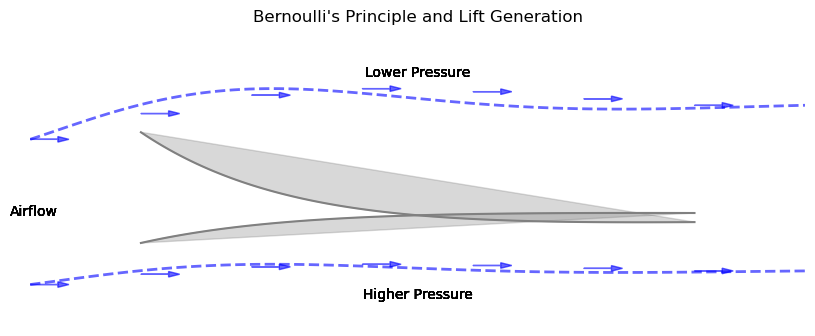

In [4]:
import matplotlib.pyplot as plt
import numpy as np 

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create airfoil shape using bezier curve
x = np.linspace(0, 10, 100) 
y_upper = 1.5 * (1 - x/5) * np.exp(-0.5 * x/2) 
y_lower = -0.5 * (1 - x/5) * np.exp(-0.5 * x/2)

# Plot airfoil
ax.fill(x, y_upper, x[::-1], y_lower[::-1], color='gray', alpha=0.3) 
ax.plot(x, y_upper, 'gray', x, y_lower, 'gray')

# Plot streamlines
x_flow = np.linspace(-2, 12, 100)

# Upper streamline
y_flow_upper = 2 + 0.5 * np.sin(x_flow/2) * np.exp(-0.2 * x_flow)

# Lower streamline
y_flow_lower = -1 + 0.2 * np.sin(x_flow/2) * np.exp(-0.2 * x_flow)

ax.plot(x_flow, y_flow_upper, 'b--', alpha=0.6, linewidth=2) 
ax.plot(x_flow, y_flow_lower, 'b--', alpha=0.6, linewidth=2)

# Add arrows for airflow direction
for i in range(-2, 12, 2): 
    ax.arrow(i, y_flow_upper[::10][i//2+1], 0.5, 0, head_width=0.1, head_length=0.2, fc='blue', ec='blue', alpha=0.6) 
    ax.arrow(i, y_flow_lower[::10][i//2+1], 0.5, 0, head_width=0.1, head_length=0.2, fc='blue', ec='blue', alpha=0.6)

# Add pressure indicators
for i in range(1, 9): # More arrows below (high pressure) ax.arrow(i, -0.8, 0, 0.2, head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.4) if i % 2 == 0: # Fewer arrows above (low pressure) ax.arrow(i, 1.8, 0, -0.2, head_width=0.1, head_length=0.1, fc='lightblue', ec='lightblue', alpha=0.4)

    # Add labels
    ax.text(5, 2.5, 'Lower Pressure', ha='center', fontsize=10) 
    ax.text(5, -1.5, 'Higher Pressure', ha='center', fontsize=10) 
    ax.text(-1.5, 0, 'Airflow', ha='right', fontsize=10)

    # Set title
    ax.set_title("Bernoulli's Principle and Lift Generation", pad=20)

    # Set axis properties
    ax.set_xlim(-2, 12) 
    ax.set_ylim(-2, 3) 
    ax.set_aspect('equal') 
    ax.axis('off')

plt.show()

# Code below from o1-preview (preview)

AttributeError: 'int' object has no attribute 'shape'

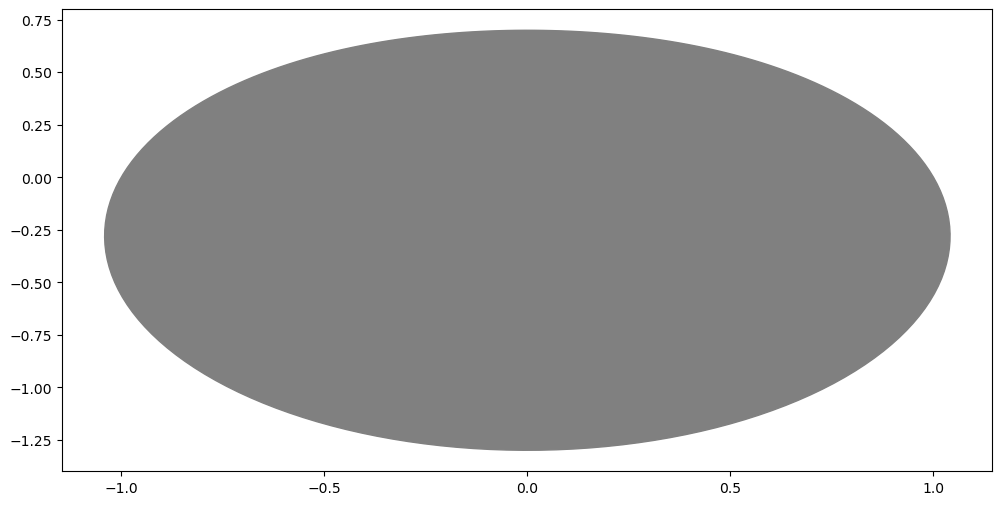

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

# Step 1: Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Step 2: Define airfoil shape
theta = np.linspace(0, 2*np.pi, 200) 
r = 1 - 0.3*np.sin(theta) 
x_airfoil = r * np.cos(theta) 
y_airfoil = r * np.sin(theta)

# Step 3: Plot airfoil
ax.fill(x_airfoil, y_airfoil, color='gray', zorder=5)

# Step 4: Generate grid for streamlines
X, Y = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-2, 2, 500))

# Step 5: Define velocity field
U = 1 
V = 0

# Modify velocity above the wing for faster airflow
speed = np.sqrt((U)**2 + (V)**2) 
V_mag = np.where(Y > 0, V + 0.5, V)

# Step 6: Create streamlines
# strm = ax.streamplot(X, Y, U, V_mag, color='blue', density=[2, 1.5], linewidth=1, arrowsize=1)
strm = ax.streamplot(X, Y, U, V_mag, color='blue', density=[2, 1.5], linewidth=1, arrowsize=1)

# Step 7: Indicate pressure difference with shading
ax.contourf(X, Y, Y, levels=0, colors=['red', 'lightblue'], alpha=0.2)

# Step 8: Add labels
ax.text(0, 1.5, 'Lower Pressure', fontsize=12, ha='center') 
ax.text(0, -1.5, 'Higher Pressure', fontsize=12, ha='center') 
ax.annotate('Airflow Direction', xy=(-2.5, 0.5), xytext=(-3, 1.5), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Step 9: Enhance visual clarity
ax.set_xlim(-3, 3) 
ax.set_ylim(-2, 2) 
ax.set_aspect('equal') 
ax.axis('off')

plt.show() 

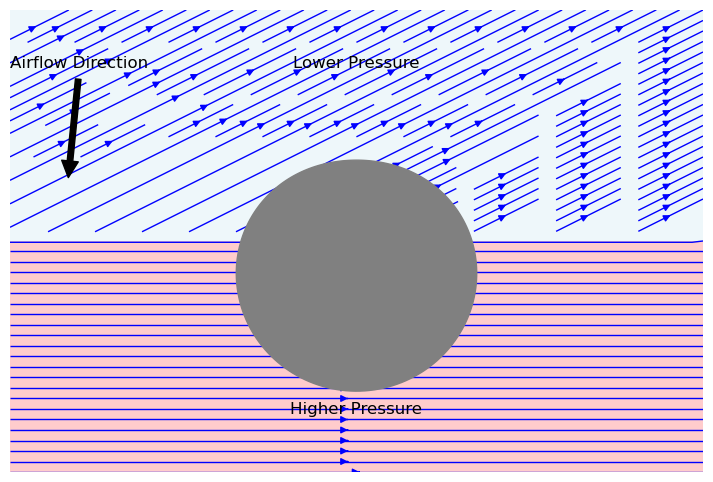

In [9]:
# Step 1: Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Step 2: Define airfoil shape
theta = np.linspace(0, 2*np.pi, 200) 
r = 1 - 0.3*np.sin(theta) 
x_airfoil = r * np.cos(theta) 
y_airfoil = r * np.sin(theta)

# Step 3: Plot airfoil
ax.fill(x_airfoil, y_airfoil, color='gray', zorder=5)

# Step 4: Generate grid for streamlines
X, Y = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-2, 2, 500))

# Step 5: Define velocity field
U = np.ones_like(X) 
V = np.zeros_like(X)

# Modify velocity above the wing for faster airflow
V = np.where(Y > 0, V + 0.5, V)

# Step 6: Create streamlines
strm = ax.streamplot(X, Y, U, V, color='blue', density=[2, 1.5], linewidth=1, arrowsize=1)

# Step 7: Indicate pressure difference with shading
ax.contourf(X, Y, Y, levels=0, colors=['red', 'lightblue'], alpha=0.2)

# Step 8: Add labels
ax.text(0, 1.5, 'Lower Pressure', fontsize=12, ha='center') 
ax.text(0, -1.5, 'Higher Pressure', fontsize=12, ha='center') 
ax.annotate('Airflow Direction', xy=(-2.5, 0.5), xytext=(-3, 1.5), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Step 9: Enhance visual clarity
ax.set_xlim(-3, 3) 
ax.set_ylim(-2, 2) 
ax.set_aspect('equal') 
ax.axis('off')

plt.show()